In [6]:
import scipy
import scipy.integrate
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import glob
import os
import re
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
rc('xtick', labelsize=20)
rc('ytick', labelsize=20)

In [45]:
# birky:   [0.0920755, -3.05439334, 3.26763974, 7.52312497, -1.1520437]
# fleming: [0.08894253, -3.0280624, 6.56208574, 7.5178048, -1.15758413]

In [22]:
def interp_lxuv(sims, **kwargs):
    
    results = np.genfromtxt(sims)
    time = results.T[0]
    lbol = results.T[1]
    lxuv = results.T[2]

    f = interp1d(time, lxuv, kind='cubic')
    
    return time, lxuv, f

def integrate_lxuv(time, lxuv, f):
    
#     int_lxuv = scipy.integrate.quad(f, time[1], max(time))[0]
    
    tarr = np.arange(time[1], max(time)+1, 1e7)
    int_lxuv = 0
    for i in range(tarr.shape[0]-1):
        int_lxuv += scipy.integrate.quad(f, tarr[i], tarr[i+1])[0]
    
    return int_lxuv

def plot_lxuv(time, lxuv, f, **kwargs):
    
    plt.figure(figsize=[8,6])
    plt.plot(time, lxuv, color='k', linewidth=3, label='VPLanet')
    plt.plot(time, f(time), color='r', linestyle='--', linewidth=3, label='Cubic Interpolation')

    plt.xlabel('Time [yr]', fontsize=20)
    plt.ylabel(r'$L_{\rm XUV} \, [L_{\odot}]$', fontsize=20)
    if 'title' in kwargs:
        plt.title(kwargs['title'], fontsize=22)
    plt.legend(loc='upper right', fontsize=18)
    plt.ylim(10**-6.3, 10**-4)
    plt.xscale('log')
    plt.yscale('log')
    if 'save' in kwargs:
        plt.savefig(kwargs['save'])
    plt.show()
    
def lum_to_flux(lum, dist):
    """
    input:
      lum  [Lsun]
      dist [cm]
    output:
      fxuv [fxuv, earth]
    """
    LSUN = 3.826e33      # erg/s
        
    return (lum * LSUN)/(4 * np.pi * dist**2) 

def flux_to_energy(flux, radius):
    
    return flux * np.pi * radius**2

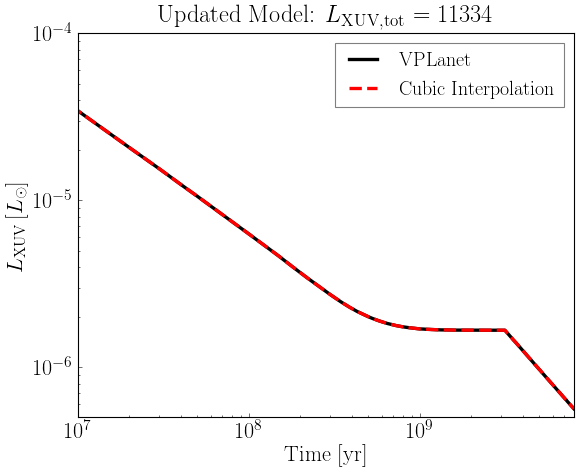

integrated flux for each planet: [1.15832803e+14 6.17473329e+13 3.11002502e+13 1.80201550e+13
 1.04080609e+13 7.03028420e+12 4.02517697e+12]
integrated energy for each planet: [1.84424844e+32 9.49168930e+31 2.46807711e+31 1.94934453e+31
 1.45207710e+31 1.14622576e+31 2.93418941e+30]


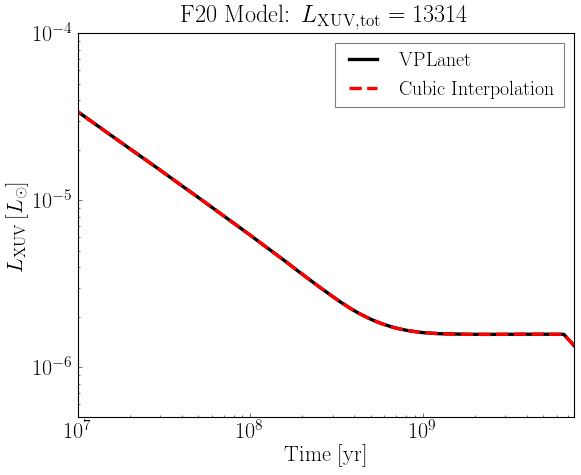

integrated flux for each planet: [1.36068895e+14 7.25346461e+13 3.65334911e+13 2.11682918e+13
 1.22263583e+13 8.25848102e+12 4.72837892e+12]
integrated energy for each planet: [2.16644025e+32 1.11498957e+32 2.89925234e+31 2.28989673e+31
 1.70575624e+31 1.34647240e+31 3.44679487e+30]


In [23]:
dist  = np.array([1.726, 2.364, 3.331, 4.376, 5.758, 7.006, 9.259]) * 1e11 # cm
radii = np.array([7.119, 6.995, 5.026, 5.868, 6.664, 7.204, 4.817]) * 1e8  # cm

time_b, lxuv_b, f_b = interp_lxuv("sims_updated/Trappist.star.forward")
lxuv_tot_b = integrate_lxuv(time_b, lxuv_b, f_b)
plot_lxuv(time_b, lxuv_b, f_b, title=r'Updated Model: $L_{\rm XUV, tot}=%.0f$'%(lxuv_tot_b), save='updated_model.png')
fxuv_b = lum_to_flux(lxuv_tot_b, dist)
energy_b = flux_to_energy(fxuv_b, radii)
print('integrated flux for each planet:', fxuv_b)
print('integrated energy for each planet:', energy_b)

time_f, lxuv_f, f_f = interp_lxuv("sims_fleming/Trappist.star.forward")
lxuv_tot_f = integrate_lxuv(time_f, lxuv_f, f_f)
plot_lxuv(time_f, lxuv_f, f_f, title=r'F20 Model: $L_{\rm XUV, tot}=%.0f$'%(lxuv_tot_f), save='fleming_model.png')
fxuv_f = lum_to_flux(lxuv_tot_f, dist)
energy_f = flux_to_energy(fxuv_f, radii)
print('integrated flux for each planet:', fxuv_f)
print('integrated energy for each planet:', energy_f)

In [24]:
lxuv_tot_b/lxuv_tot_f

0.8512805425965824

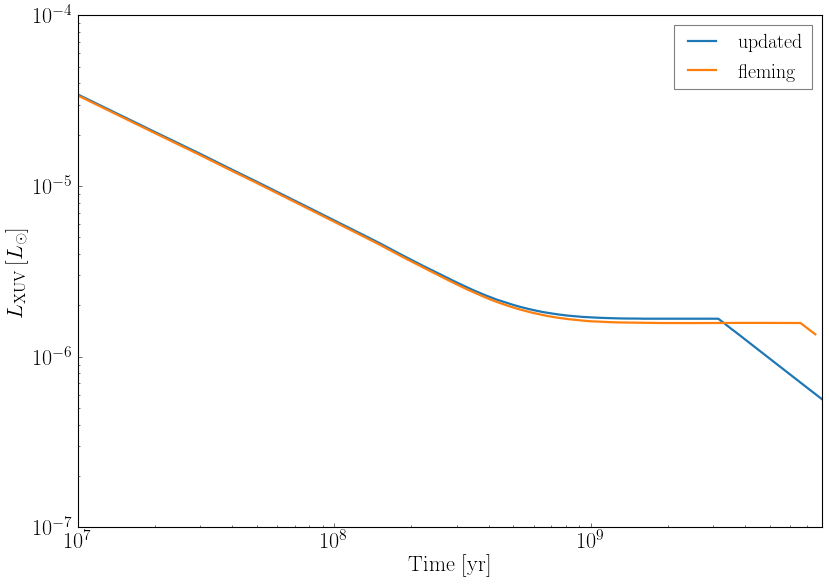

In [10]:
time_b, lxuv_b, f = interp_lxuv("sims_updated/Trappist.star.forward")
time_f, lxuv_f, f = interp_lxuv("sims_fleming/Trappist.star.forward")

plt.plot(time_b, lxuv_b, label='updated')
plt.plot(time_f, lxuv_f, label='fleming')

plt.xlabel('Time [yr]', fontsize=20)
plt.ylabel(r'$L_{\rm XUV} \, [L_{\odot}]$', fontsize=20)
plt.legend(loc='upper right', fontsize=18)
plt.ylim(10**-7, 10**-4)
plt.xscale('log')
plt.yscale('log')
plt.savefig('comparison.png')
plt.show()

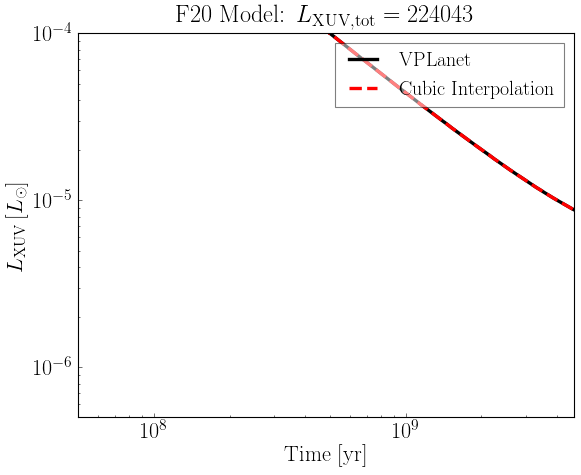

integrated flux for earth: [3.04791978e+11]
integrated energy for earth: [4.63444157e+29]


In [28]:
dist  = np.array([1.496]) * 1e13
radii = np.array([6.957]) * 1e8

time_s, lxuv_s, f_s = interp_lxuv("sims_earth/sun.sun.forward")
lxuv_tot_s = integrate_lxuv(time_s, lxuv_s, f_s)
plot_lxuv(time_s, lxuv_s, f_s, title=r'F20 Model: $L_{\rm XUV, tot}=%.0f$'%(lxuv_tot_s), save='sun_model.png')
fxuv_s = lum_to_flux(lxuv_tot_s, dist)
energy_s = flux_to_energy(fxuv_s, radii)
print('integrated flux for earth:', fxuv_s)
print('integrated energy for earth:', energy_s)